In [167]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import time
import seaborn as sns

import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

import analysis_utils as aute

In [233]:
class Parameters:
    path_to_cuest = "../Cuestionarios/"
    emot_states = ['Angry', 'Relax', 'Sad', 'Happy']
    subj_no_depress_list = [
        'USER_48_CB2', 'USER_47_CB2', 'USER_45_CB2', 'USER_43_CB2', 'USER_42_CB2', 'USER_40_CB2', 'USER_39_CB2',
        'USER_38_CB2', 'USER_24_CB2', 'USER_17_CB2', 'USER_15_CB2', 'USER_12_CB2', 'USER_10_CB2', 'USER_09_CB2', 
        'USER_07_CB2', 'USER_06_CB2', 'USER_05_CB2', 'USER_04_CB2', 'USER_03_CB2', 'USER_02_CB2', 'USER_01_CB2', 
        'USER_52_CB', 'USER_51_CB', 'USER_50_CB', 'USER_49_CB', 'USER_48_CB', 'USER_47_CB', 'USER_46_CB', 
        'USER_45_CB', 'USER_44_CB', 'USER_43_CB', 'USER_42_CB', 'USER_41_CB', 'USER_40_CB', 'USER_39_CB', 
        'USER_38_CB', 'USER_37_CB', 'USER_36_CB', 'USER_35_CB', 'USER_34_CB', 'USER_33_CB', 'USER_30_CB', 
        'USER_29_CB', 'USER_28_CB', 'USER_27_CB', 'USER_25_CB', 'USER_24_CB', 'USER_23_CB', 'USER_22_CB', 
        'USER_21_CB', 'USER_20_CB', 'USER_19_CB', 'USER_18_CB', 'USER_17_CB', 'USER_15_CB', 'USER_14_CB', 
        'USER_13_CB', 'USER_10_CB', 'USER_09_CB', 'USER_07_CB', 'USER_05_CB', 'USER_03_CB', 'USER_02_CB', 
        'USER_01_CB'
    ]

## Conversation duration

In [169]:
all_df_list = []
for file in os.listdir("../PostProcessedConversations/"):
    df_x = pd.read_csv("../PostProcessedConversations/" + file, sep=";")
    all_df_list.append(df_x)
    
print("Number of conversations:", len(all_df_list))

Number of conversations: 579


In [182]:
delta_time_list = []
for df in all_df_list:
    start_t = df["BotTalkStartUnix"].iloc[0]
    
    last_source = df["Source"].iloc[-1]
    end_t = df[last_source + "TalkEndUnix"].iloc[-1]

    delta_time_list.append((end_t - start_t)/60)

delta_time_array = np.array(delta_time_list)

In [197]:
np.round(100 * np.mean(delta_time_array > 4), 3)

42.66

Mean Conversation time (min) = 3.421 +/- 0.971 ; Median = 3.58 ; Min. =  0.649 ; Max. =  4.807


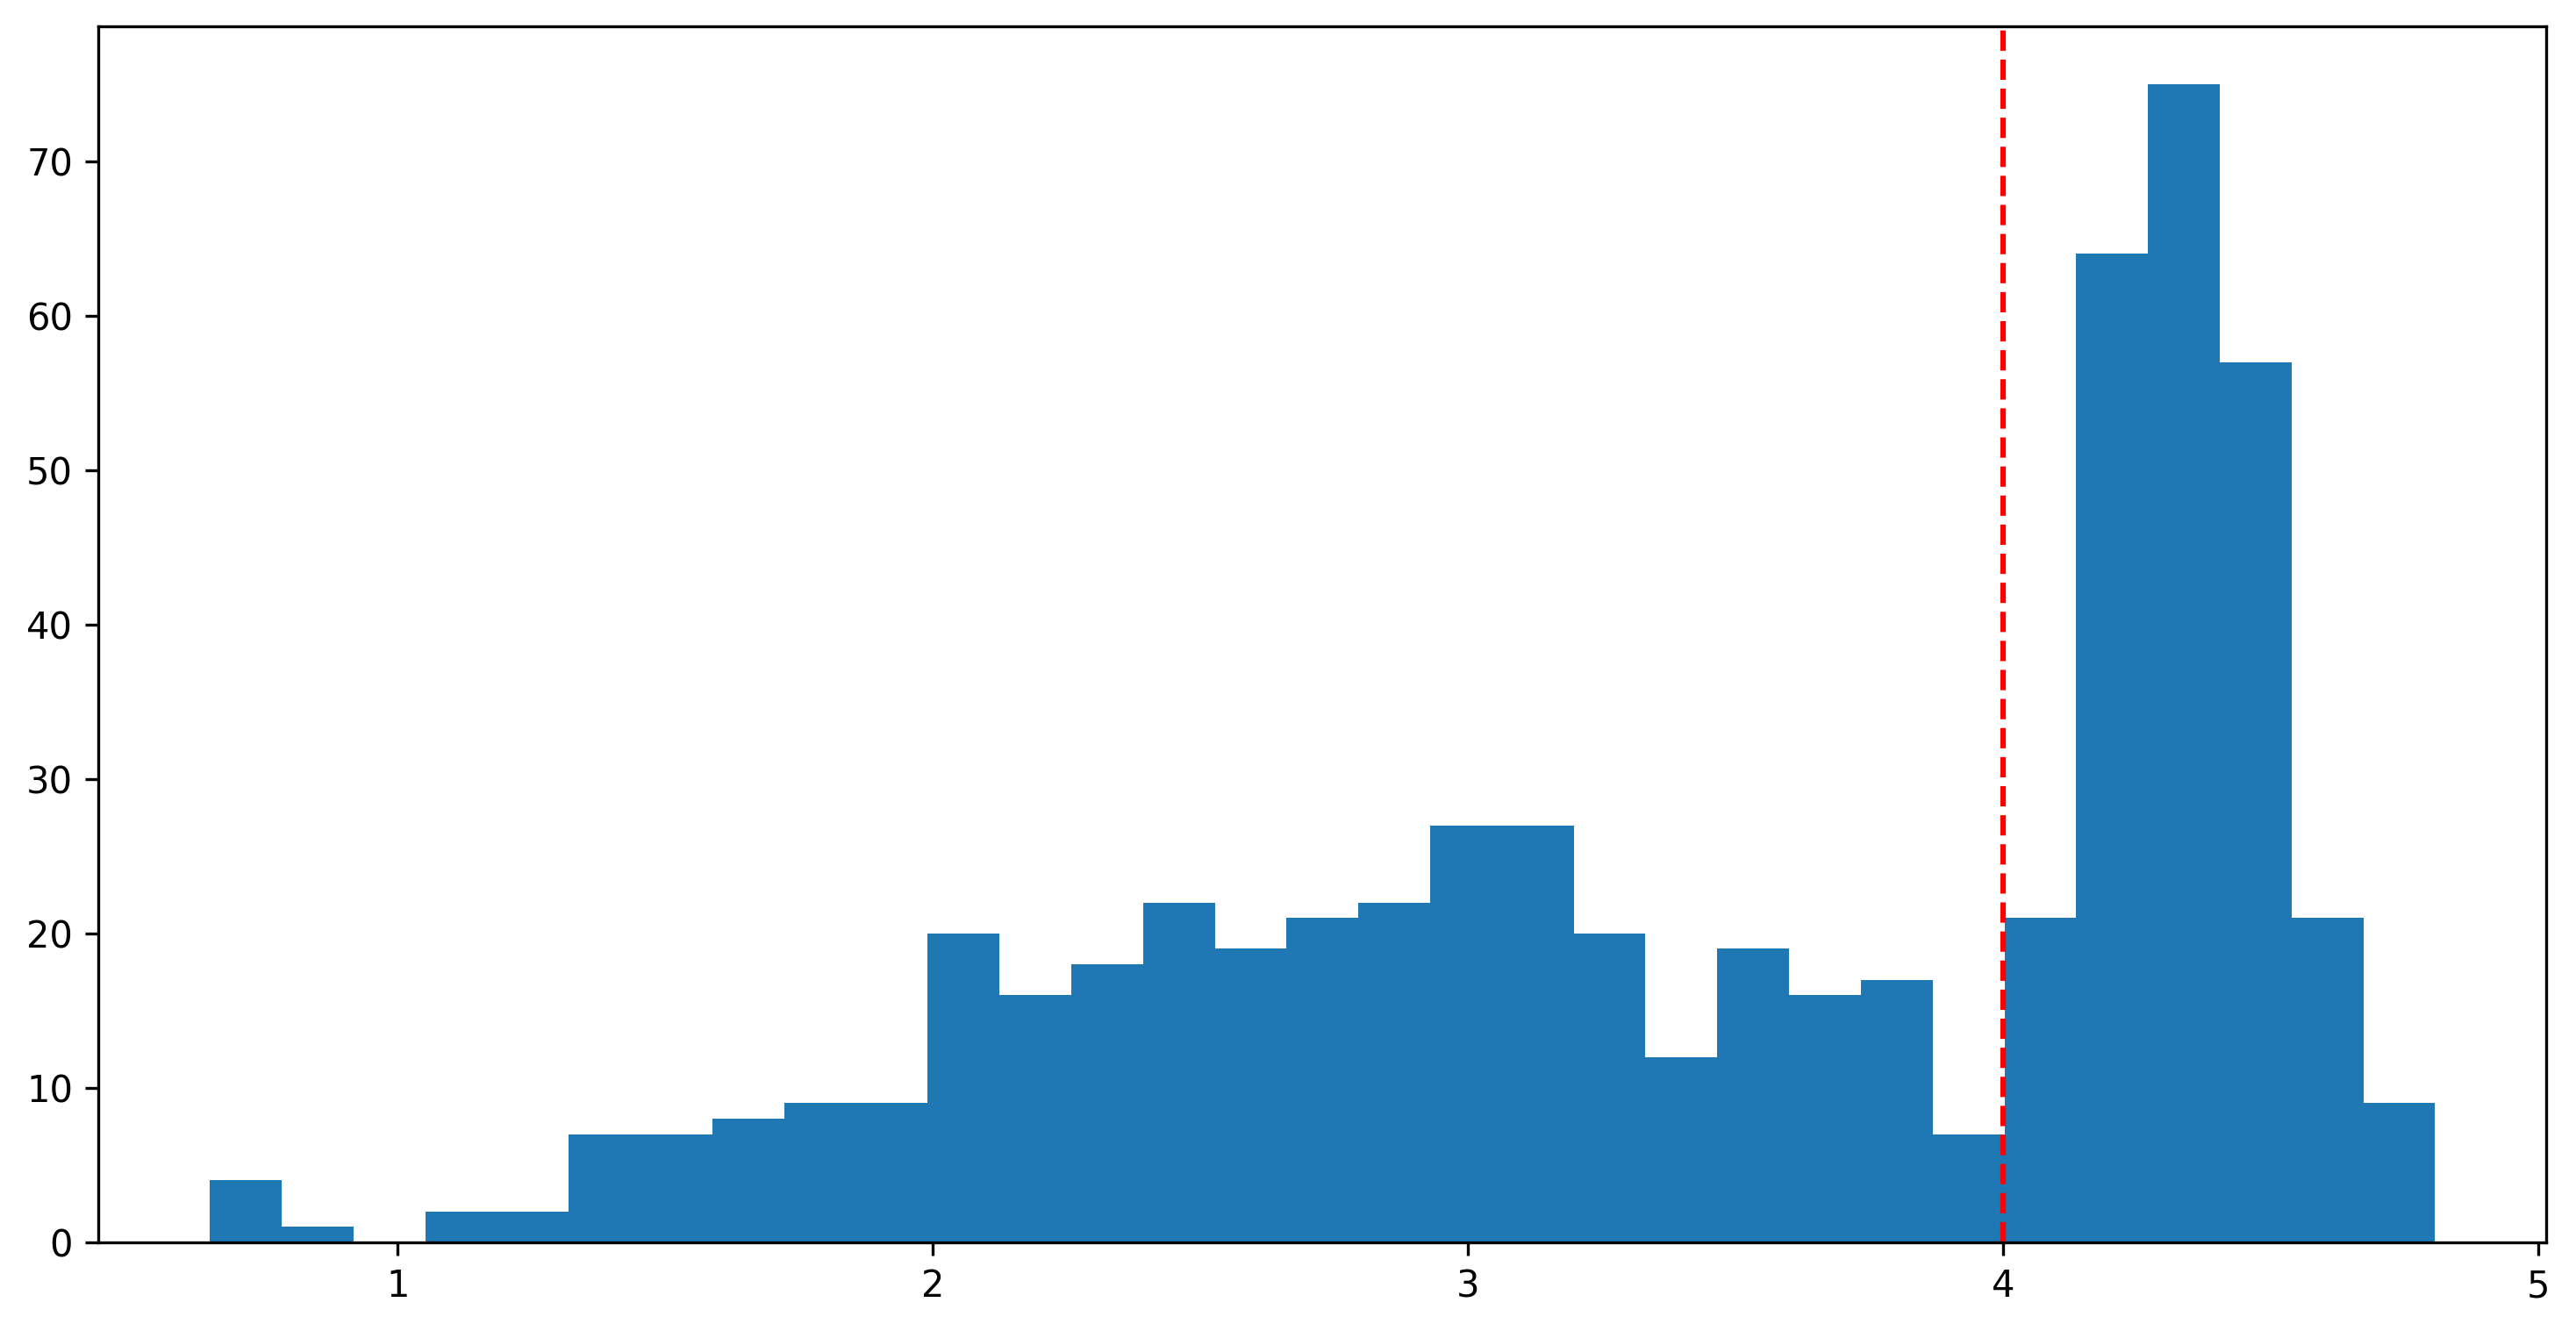

In [194]:
aute.stat_print(delta_time_array, "Conversation time (min)", 3)

plt.figure(figsize=(12, 6), dpi=300)
plt.hist(delta_time_array, bins=31)
plt.axvline(4, linestyle="--", c="red")

# plt.show()

plt.savefig("Results/TimeConvDuration.pdf", dpi=300, format="pdf")

In [189]:
time_below_4 = delta_time_array[delta_time_array <= 4]
aute.stat_print(time_below_4, "time below 4 min -> ")

Mean time below 4 min ->  = 2.7302 +/- 0.7123 ; Median = 2.8002 ; Min. =  0.649 ; Max. =  3.966


In [192]:
time_above_4 = delta_time_array[delta_time_array > 4]
aute.stat_print(time_above_4, "time above 4 min -> ")
aute.stat_print(time_above_4 - 4, "time above 4 min -> ")

Mean time above 4 min ->  = 4.3493 +/- 0.1626 ; Median = 4.3394 ; Min. =  4.0116 ; Max. =  4.8071
Mean time above 4 min ->  = 0.3493 +/- 0.1626 ; Median = 0.3394 ; Min. =  0.0116 ; Max. =  0.8071


## Did the emotion elicitation and identification vary among male and female participants or between male and female virtual humans?

### PHQ-9

To filter which subjects are NOT depressive.

In [198]:
df_phq9 = pd.read_excel("../Cuestionarios/CHATBOTs_PHQ-9.xlsx", skiprows=[1])
user_name_column = [user.replace("User", "USER") if isinstance(user, str) else np.nan for user in df_phq9["Usuario"].values]
df_phq9["SubjectId"] = user_name_column

cols_to_sum = [
    'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
    'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
    'Unnamed: 19'
]

dict_to_replace = {
    "Ningún dia": 0,
    "Varios días": 1,
    "Más de la mitad de los días": 2,
    "Casi todos los días": 3
}

for col in cols_to_sum:
    df_phq9[col] = df_phq9[col].replace(dict_to_replace)

df_phq9["TotalSum"] = np.nansum(df_phq9[cols_to_sum], axis=1)
phq9_th_depress = 10

all_users_no_depress = df_phq9[df_phq9["TotalSum"] < phq9_th_depress]["SubjectId"].values
subj_no_depress_list = [
    subj for subj in all_users_no_depress if isinstance(subj, str) and "CB" in subj and not "P" in subj
]
print("Num of subjects", len(subj_no_depress_list))

Num of subjects 64


### Demographics

In [199]:
df_demo = pd.read_csv(Parameters.path_to_cuest + "PostProcessedCuest/DemographicPostProc.csv", sep=";")
df_demo["GenderMale"] = ((df_demo["GenderFem"] == 0) * (df_demo["GenderOther"] == 0)) * 1
print("Demo shape without clean subjects", df_demo.shape)

idx_clean = []
for i_us, us in df_demo["SubjectId"].to_dict().items():
    if np.sum(np.array(subj_no_depress_list) == us) == 1:
        idx_clean.append(i_us)
    # else:
        # print(us)
# idx_clean = [i_us for i_us, us in enumerate(df_angry["Usuario"])]
df_demo = df_demo.loc[idx_clean]
print("Demo shape only NO depressive", df_demo.shape)

Demo shape without clean subjects (114, 49)
Demo shape only NO depressive (64, 49)


In [200]:
print("Number of females", np.sum(df_demo["GenderFem"] == 1))
print("Number of males", np.sum(df_demo["GenderMale"] == 1))

Number of females 32
Number of males 31


### Questionnaires

In [201]:
df_angry = pd.read_csv("../Cuestionarios/PostProcessedCuest/CuestAvatarAngry.csv")
idx_clean = []
for i_us, us in df_angry["SubjectId"].to_dict().items():
    if np.sum(np.array(subj_no_depress_list) == us) == 1:
        idx_clean.append(i_us)
    # else:
        # print(us)
# idx_clean = [i_us for i_us, us in enumerate(df_angry["Usuario"])]
df_angry = df_angry.loc[idx_clean]
df_angry["Personality"] = "Angry"

df_happy = pd.read_csv("../Cuestionarios/PostProcessedCuest/CuestAvatarHappy.csv")
idx_clean = []
for i_us, us in df_happy["SubjectId"].to_dict().items():
    if np.sum(np.array(subj_no_depress_list) == us) == 1:
        idx_clean.append(i_us)
# idx_clean = [i_us for i_us, us in enumerate(df_angry["Usuario"])]
df_happy = df_happy.loc[idx_clean]
df_happy["Personality"] = "Happy"

df_relax = pd.read_csv("../Cuestionarios/PostProcessedCuest/CuestAvatarRelax.csv")
idx_clean = []
for i_us, us in df_relax["SubjectId"].to_dict().items():
    if np.sum(np.array(subj_no_depress_list) == us) == 1:
        idx_clean.append(i_us)
# idx_clean = [i_us for i_us, us in enumerate(df_angry["Usuario"])]
df_relax = df_relax.loc[idx_clean]
df_relax["Personality"] = "Relax"

df_sad = pd.read_csv("../Cuestionarios/PostProcessedCuest/CuestAvatarSad.csv")
idx_clean = []
for i_us, us in df_sad["SubjectId"].to_dict().items():
    if np.sum(np.array(subj_no_depress_list) == us) == 1:
        idx_clean.append(i_us)
# idx_clean = [i_us for i_us, us in enumerate(df_angry["Usuario"])]
df_sad = df_sad.loc[idx_clean]
df_sad["Personality"] = "Sad"

df_neutral1 = pd.read_csv("../Cuestionarios/PostProcessedCuest/CuestAvatarN1.csv")
idx_clean = []
for i_us, us in df_neutral1["SubjectId"].to_dict().items():
    if np.sum(np.array(subj_no_depress_list) == us) == 1:
        idx_clean.append(i_us)
# idx_clean = [i_us for i_us, us in enumerate(df_angry["Usuario"])]
df_neutral1 = df_neutral1.loc[idx_clean]
df_neutral1["Personality"] = "Neutral1"

df_neutral2 = pd.read_csv("../Cuestionarios/PostProcessedCuest/CuestAvatarN2.csv")
idx_clean = []
for i_us, us in df_neutral2["SubjectId"].to_dict().items():
    if np.sum(np.array(subj_no_depress_list) == us) == 1:
        idx_clean.append(i_us)
# idx_clean = [i_us for i_us, us in enumerate(df_angry["Usuario"])]
df_neutral2 = df_neutral2.loc[idx_clean]
df_neutral2["Personality"] = "Neutral2"

df_all_cuest = pd.concat([df_angry, df_happy, df_relax, df_sad, df_neutral1, df_neutral2]).reset_index(drop=True)
print("Shape of all quest.", df_all_cuest.shape)

Shape of all quest. (379, 35)


### To check VH gender

In [202]:
time_evol_nr_list = []
for subj in subj_no_depress_list:
    
    path_to_got = "../Conversations/" + subj + "_Conversations/GuideOfTimes.csv"
    
    try:
        df_got = pd.read_csv(path_to_got, sep=";")
    except:
        print("Bad subject", path_to_got)
        continue
    
    for i in range(0, df_got.shape[0], 2):

        event = df_got["Event"].iloc[i]
        if "_" not in event:
            continue

        emotion, gender, vh_form, _ = event.split("_")
        
        time_evol_nr_list.append({
            "Subject": subj,
            "VHEmotion": emotion,
            "VHGender": gender,
            "VHForm": vh_form
        })

df_order_vh_info = pd.DataFrame(time_evol_nr_list)
display(df_order_vh_info.head(10))

print("Shape of the data", df_order_vh_info.shape)

Bad subject ../Conversations/USER_48_CB2_Conversations/GuideOfTimes.csv
Bad subject ../Conversations/USER_47_CB2_Conversations/GuideOfTimes.csv


,Subject,VHEmotion,VHGender,VHForm
0,USER_45_CB2,Neutral,Female,1
1,USER_45_CB2,Neutral,Male,2
2,USER_45_CB2,Happy,Woman,1
3,USER_45_CB2,Relax,Man,2
4,USER_45_CB2,Sad,Woman,2
5,USER_45_CB2,Angry,Man,1
6,USER_43_CB2,Neutral,Female,1
7,USER_43_CB2,Neutral,Male,2
8,USER_43_CB2,Angry,Woman,2
9,USER_43_CB2,Sad,Man,2


Shape of the data (377, 4)


In [203]:
df_demo

,Unnamed: 0,respondent_id,collector_id,date_created,date_modified,ip_address,email_address,first_name,last_name,custom_1,...,Unnamed: 38,AgeYears,GenderFem,GenderOther,NumHPlayVGame,PlayVGame,OrdinalPs,NoMedicine,SubjectId,GenderMale
2,2,118253913984,448136109,2023-02-27 11:04:52,2023-02-27 11:10:44,158.42.142.216,NaN,NaN,NaN,NaN,...,NaN,21.47,0,0,1.0,1,0,1,USER_48_CB2,1
3,3,118253843725,448136109,2023-02-27 08:58:26,2023-02-27 09:05:29,158.42.142.216,NaN,NaN,NaN,NaN,...,NaN,19.12,0,0,2.0,1,1,1,USER_47_CB2,1
5,5,118251986379,448136109,2023-02-24 11:21:14,2023-02-24 11:29:56,158.42.142.216,NaN,NaN,NaN,NaN,...,NaN,33.89,0,0,1.0,1,0,1,USER_45_CB2,1
7,7,118251074759,448136109,2023-02-23 12:59:47,2023-02-23 13:02:21,158.42.142.216,NaN,NaN,NaN,NaN,...,NaN,42.29,0,0,NaN,0,3,1,USER_43_CB2,1
8,8,118251011923,448136109,2023-02-23 08:30:37,2023-02-23 11:08:35,158.42.142.216,NaN,NaN,NaN,NaN,...,NaN,55.35,0,0,1.0,1,0,1,USER_42_CB2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,97,118179941600,448136109,2022-11-18 08:29:38,2022-11-18 08:53:54,158.42.69.160,NaN,NaN,NaN,NaN,...,NaN,47.12,1,0,NaN,0,0,1,USER_07_CB,0
99,99,118178971670,448136109,2022-11-17 10:48:41,2022-11-17 11:11:37,158.42.69.160,NaN,NaN,NaN,NaN,...,NaN,32.51,0,0,NaN,0,1,1,USER_05_CB,1
101,101,118177952679,448136109,2022-11-16 13:01:38,2022-11-16 13:06:57,158.42.69.160,NaN,NaN,NaN,NaN,...,NaN,21.01,1,0,NaN,0,0,1,USER_03_CB,0
102,102,118177863391,448136109,2022-11-16 10:35:03,2022-11-16 10:46:56,158.42.69.160,NaN,NaN,NaN,NaN,...,NaN,43.17,1,0,NaN,0,0,1,USER_02_CB,0


In [204]:
df_merge = df_all_cuest.merge(df_order_vh_info, left_on=["SubjectId", "Personality"], right_on=["Subject", "VHEmotion"])
demo_cols_list = ['AgeYears', 'GenderFem', 'GenderOther', 'NumHPlayVGame', 'PlayVGame', 'OrdinalPs', 'NoMedicine', 'SubjectId', 'GenderMale']
df_merge = df_merge.merge(df_demo[demo_cols_list], left_on="SubjectId", right_on="SubjectId")

In [91]:
df_vh_man = df_merge[df_merge["VHGender"] == "Man"].reset_index(drop=True)
print("VH MAN", df_vh_man.shape)

df_vh_woman = df_merge[df_merge["VHGender"] == "Woman"].reset_index(drop=True)
print("VH WOMAN", df_vh_woman.shape)

VH MAN (124, 47)
VH WOMAN (124, 47)


In [210]:
df_vh_man["Subject"]

0      USER_45_CB2
1      USER_45_CB2
2      USER_43_CB2
3      USER_43_CB2
4      USER_42_CB2
          ...     
119     USER_02_CB
120     USER_01_CB
121     USER_01_CB
122    USER_39_CB2
123    USER_10_CB2
Name: Subject, Length: 124, dtype: object

In [215]:
quest_to_keep_list = [
    'Question1', 'Question2', 'Question3', 'Question4', 'Question6', 'Question7'
]

# ##############
# ### VH MAN ###
# ##############

vh_man_study_list = []
for subj, df_subj in df_vh_man.groupby("Subject"):
    dict_help = {
        "Label": "VH_MAN",
        "Subject": subj
    }

    for quest in quest_to_keep_list:
        dict_help[quest] = np.nanmean(df_subj[quest].values)
    
    vh_man_study_list.append(dict_help)

df_vh_man_avg = pd.DataFrame(vh_man_study_list)
print("VH Man shape", df_vh_man_avg.shape)
display(df_vh_man_avg.head(5))

# #################
# ### VH FEMALE ###
# #################

vh_woman_study_list = []
for subj, df_subj in df_vh_woman.groupby("Subject"):
    dict_help = {
        "Label": "VH_woMAN",
        "Subject": subj
    }

    for quest in quest_to_keep_list:
        dict_help[quest] = np.nanmean(df_subj[quest].values)
    
    vh_woman_study_list.append(dict_help)

df_vh_woman_avg = pd.DataFrame(vh_woman_study_list)
print("VH woMan shape", df_vh_woman_avg.shape)
display(df_vh_woman_avg.head(5))

VH Man shape (62, 8)


,Label,Subject,Question1,Question2,Question3,Question4,Question6,Question7
0,VH_MAN,USER_01_CB,5.500000,5.500000,7.0,6.000000,5.500000,6.000000
1,VH_MAN,USER_01_CB2,5.000000,5.000000,5.0,4.000000,5.500000,5.500000
2,VH_MAN,USER_02_CB,1.666667,4.333333,3.0,5.333333,5.666667,6.666667
3,VH_MAN,USER_02_CB2,4.000000,3.500000,4.5,5.500000,3.000000,5.500000
4,VH_MAN,USER_03_CB,4.500000,3.500000,3.5,6.000000,7.000000,7.500000


VH woMan shape (62, 8)


,Label,Subject,Question1,Question2,Question3,Question4,Question6,Question7
0,VH_woMAN,USER_01_CB,4.333333,4.666667,6.333333,5.666667,5.666667,5.0
1,VH_woMAN,USER_01_CB2,6.000000,5.500000,6.500000,2.500000,7.000000,2.5
2,VH_woMAN,USER_02_CB,4.000000,4.500000,4.500000,5.000000,5.500000,4.5
3,VH_woMAN,USER_02_CB2,6.000000,6.500000,5.000000,7.000000,5.000000,8.0
4,VH_woMAN,USER_03_CB,6.000000,6.500000,9.000000,7.000000,8.500000,7.0


In [221]:
for quest in quest_to_keep_list:
    _, p_value_man = sp.stats.shapiro(df_vh_man_avg[quest])
    print("Man question", quest, "p-value", p_value_man, aute.get_p_string(p_value_man))

    _, p_value_woman = sp.stats.shapiro(df_vh_woman_avg[quest])
    print("Woman question", quest, "p-value", p_value_woman, aute.get_p_string(p_value_woman))

    if p_value_man < 0.05 or p_value_woman < 0.05:
        _, p_value = sp.stats.wilcoxon(df_vh_man_avg[quest], df_vh_woman_avg[quest])
        print("No normal ; Question", quest, "p-value", p_value, aute.get_p_string(p_value))
    else:
        _, p_value = sp.stats.ttest_rel(df_vh_man_avg[quest], df_vh_woman_avg[quest])
        print("Normal ; Question", quest, "p-value", p_value, aute.get_p_string(p_value))

    print()

Man question Question1 p-value 0.0008207792998291552 ***
Woman question Question1 p-value 0.0016429219394922256 **
No normal ; Question Question1 p-value 0.07527893261871896 -

Man question Question2 p-value 0.01942397840321064 *
Woman question Question2 p-value 0.027720671147108078 *
No normal ; Question Question2 p-value 0.07296319868924901 -

Man question Question3 p-value 0.17368003726005554 -
Woman question Question3 p-value 0.003616615664213896 **
No normal ; Question Question3 p-value 0.005564788271390078 **

Man question Question4 p-value 0.0004078085476066917 ***
Woman question Question4 p-value 0.028660273179411888 *
No normal ; Question Question4 p-value 0.24052970362491377 -

Man question Question6 p-value 0.11474070698022842 -
Woman question Question6 p-value 0.07609137147665024 -
Normal ; Question Question6 p-value 0.0002477032021539535 ***

Man question Question7 p-value 0.006671084091067314 **
Woman question Question7 p-value 0.04013610631227493 *
No normal ; Question Q

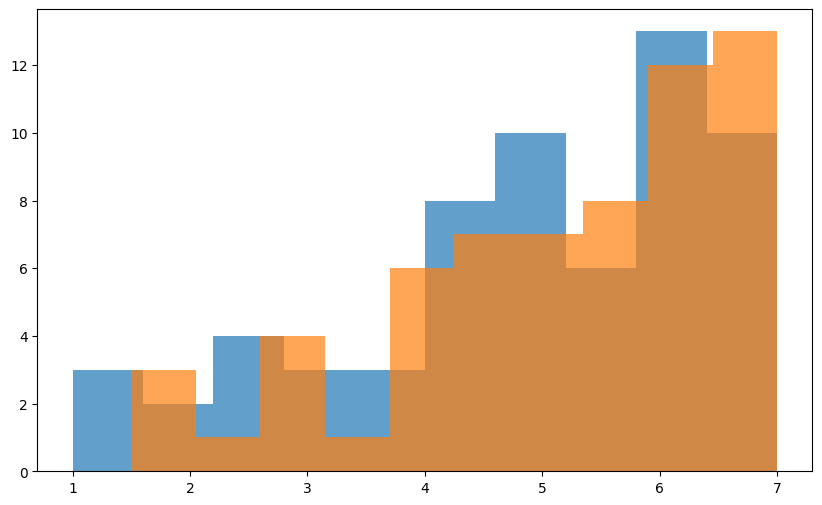

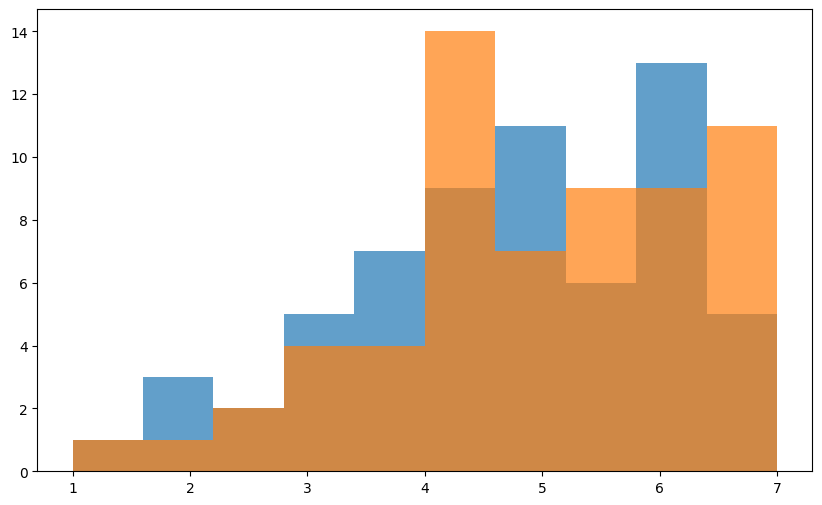

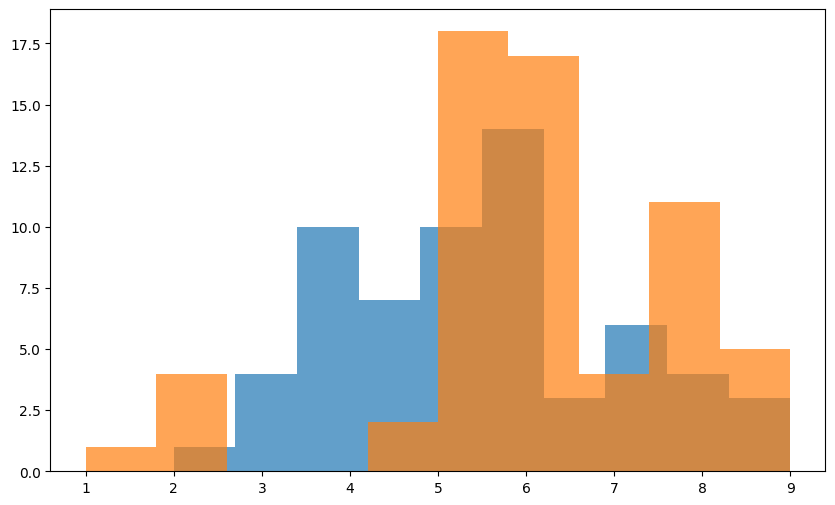

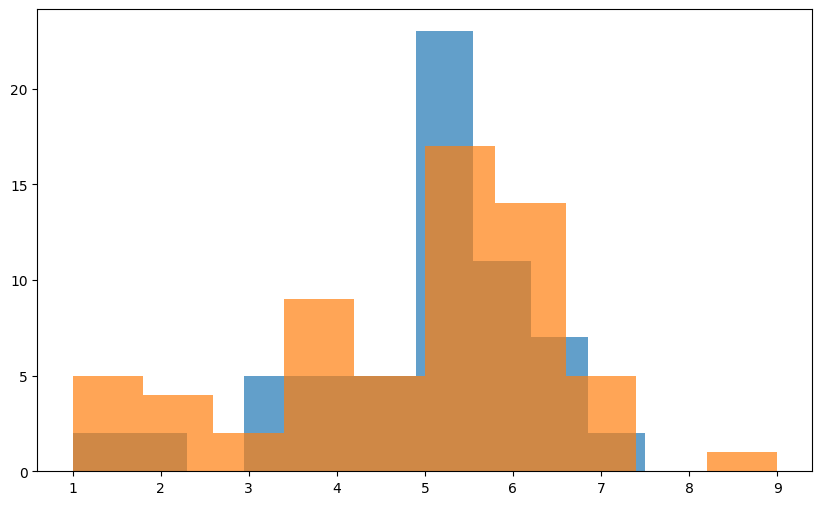

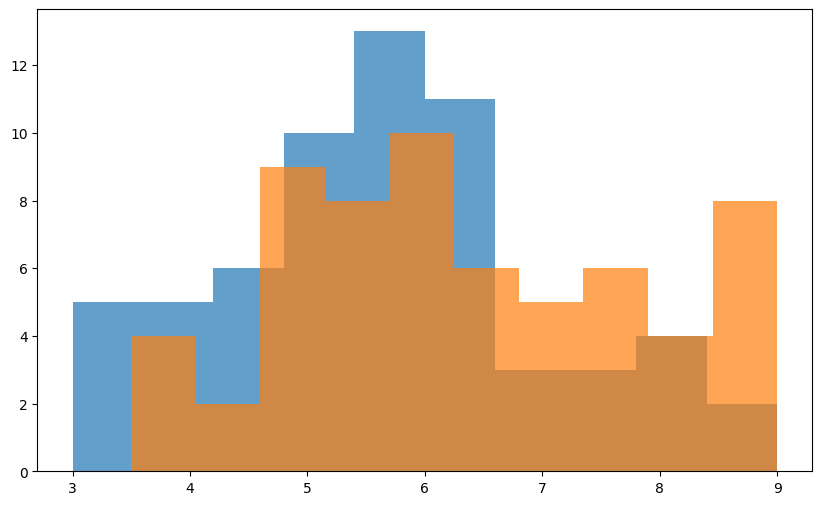

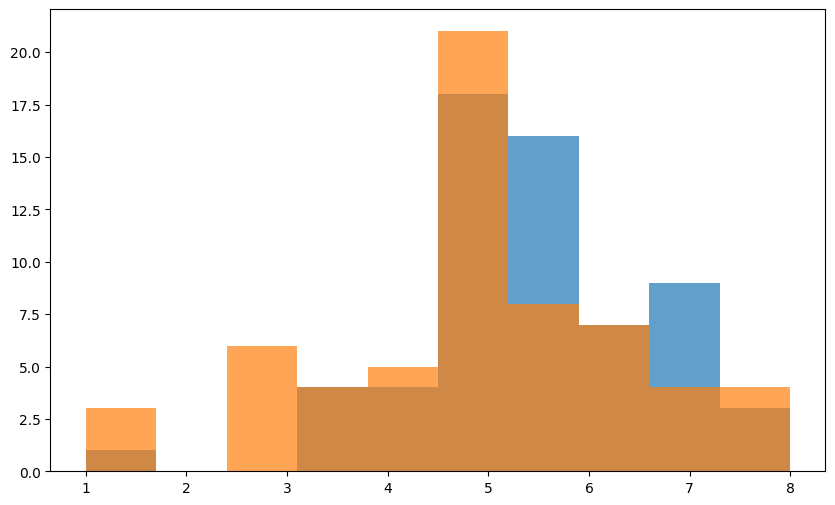

In [216]:
for quest in quest_to_keep_list:
    plt.figure(figsize=(10, 6))

    plt.hist(df_vh_man_avg[quest], alpha=0.7)
    plt.hist(df_vh_woman_avg[quest], alpha=0.7)
    
    plt.show()

### For humans

In [226]:
df_pers_man = df_merge[df_merge["GenderMale"] == 1].reset_index(drop=True)
print("PERSON male", df_pers_man.shape)

df_pers_woman = df_merge[df_merge["GenderFem"] == 1].reset_index(drop=True)
print("PERSON WOMAN", df_pers_woman.shape)

PERSON male (117, 47)
PERSON WOMAN (127, 47)


In [227]:
quest_to_keep_list = [
    'Question1', 'Question2', 'Question3', 'Question4', 'Question6', 'Question7'
]

# ##############
# ### Person MAN ###
# ##############

pers_man_study_list = []
for subj, df_subj in df_pers_man.groupby("Subject"):
    dict_help = {
        "Label": "MAN",
        "Subject": subj
    }

    for quest in quest_to_keep_list:
        dict_help[quest] = np.nanmean(df_subj[quest].values)
    
    pers_man_study_list.append(dict_help)

df_pers_man_avg = pd.DataFrame(pers_man_study_list)
print("Person Man shape", df_pers_man_avg.shape)
display(df_pers_man_avg.head(5))

# #################
# ### VH FEMALE ###
# #################

pers_woman_study_list = []
for subj, df_subj in df_pers_woman.groupby("Subject"):
    dict_help = {
        "Label": "WOMAN",
        "Subject": subj
    }

    for quest in quest_to_keep_list:
        dict_help[quest] = np.nanmean(df_subj[quest].values)
    
    pers_woman_study_list.append(dict_help)

df_pers_woman_avg = pd.DataFrame(pers_woman_study_list)
print("Person Woman shape", df_pers_woman_avg.shape)
display(df_pers_woman_avg.head(5))

Person Man shape (29, 8)


,Label,Subject,Question1,Question2,Question3,Question4,Question6,Question7
0,MAN,USER_01_CB,4.80,5.00,6.60,5.80,5.60,5.40
1,MAN,USER_01_CB2,5.50,5.25,5.75,3.25,6.25,4.00
2,MAN,USER_02_CB2,5.00,5.00,4.75,6.25,4.00,6.75
3,MAN,USER_03_CB2,2.25,2.75,3.00,5.75,3.25,6.25
4,MAN,USER_05_CB,4.25,3.50,5.75,3.00,5.25,4.75


Person Woman shape (32, 8)


,Label,Subject,Question1,Question2,Question3,Question4,Question6,Question7
0,WOMAN,USER_02_CB,2.60,4.40,3.60,5.20,5.60,5.80
1,WOMAN,USER_03_CB,5.25,5.00,6.25,6.50,7.75,7.25
2,WOMAN,USER_04_CB2,6.00,6.00,7.50,3.25,7.25,3.75
3,WOMAN,USER_06_CB2,3.50,3.75,5.00,5.25,6.00,3.75
4,WOMAN,USER_07_CB,6.00,5.75,8.25,1.75,8.25,4.50


In [228]:
for quest in quest_to_keep_list:
    _, p_value_man = sp.stats.shapiro(df_pers_man_avg[quest])
    print("Man question", quest, "p-value", p_value_man, aute.get_p_string(p_value_man))

    _, p_value_woman = sp.stats.shapiro(df_pers_woman_avg[quest])
    print("Woman question", quest, "p-value", p_value_woman, aute.get_p_string(p_value_woman))

    if p_value_man < 0.05 or p_value_woman < 0.05:
        _, p_value = sp.stats.mannwhitneyu(df_pers_man_avg[quest], df_pers_woman_avg[quest])
        print("No normal ; Question", quest, "p-value", p_value, aute.get_p_string(p_value))
    else:
        _, p_value = sp.stats.ttest_ind(df_pers_man_avg[quest], df_pers_woman_avg[quest])
        print("Normal ; Question", quest, "p-value", p_value, aute.get_p_string(p_value))

    print()

Man question Question1 p-value 0.5641659498214722 -
Woman question Question1 p-value 0.0026342866476625204 **
No normal ; Question Question1 p-value 0.19502117475252512 -

Man question Question2 p-value 0.49509429931640625 -
Woman question Question2 p-value 0.007286553271114826 **
No normal ; Question Question2 p-value 0.10331474767165509 -

Man question Question3 p-value 0.3046574592590332 -
Woman question Question3 p-value 0.5244887471199036 -
Normal ; Question Question3 p-value 0.7791575428834715 -

Man question Question4 p-value 0.19032709300518036 -
Woman question Question4 p-value 0.19302481412887573 -
Normal ; Question Question4 p-value 0.7749175075965825 -

Man question Question6 p-value 0.8422293663024902 -
Woman question Question6 p-value 0.09899331629276276 -
Normal ; Question Question6 p-value 0.8039927911671781 -

Man question Question7 p-value 0.03752926364541054 *
Woman question Question7 p-value 0.790948748588562 -
No normal ; Question Question7 p-value 0.37255935449672

### Other things

Emotion Angry
Emotion elicitation (Question3 -> Valencia; Question4 -> Arousal)


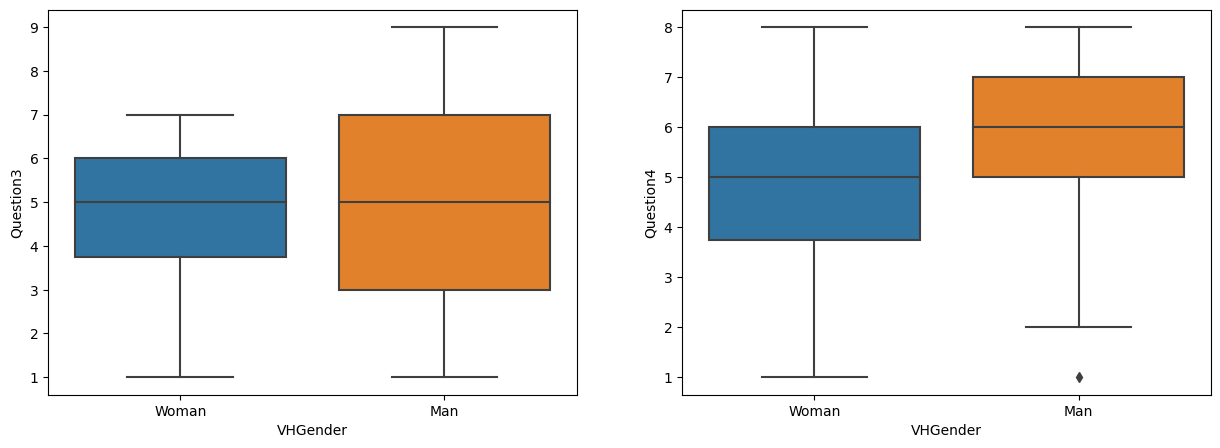

Emotion recognition (Question6 -> Valencia; Question7 -> Arousal)


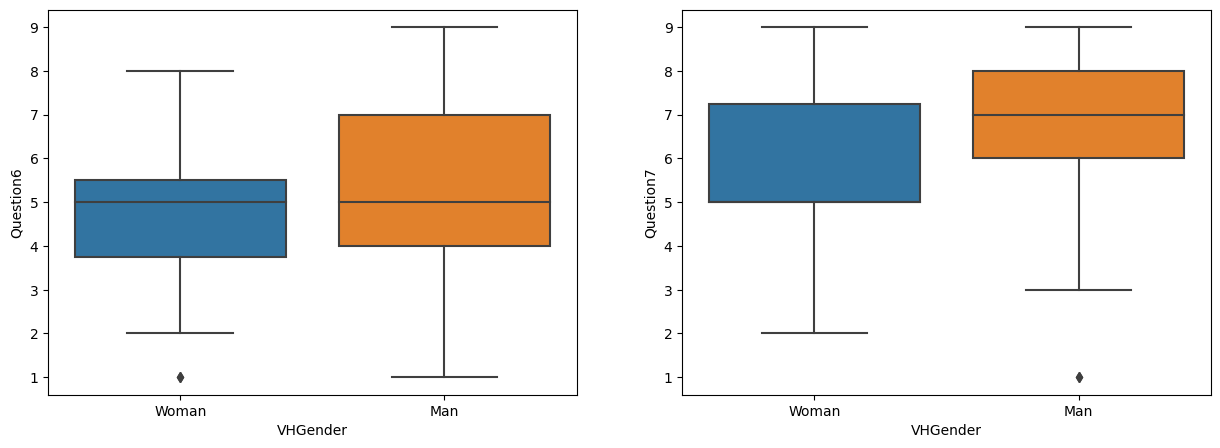


Emotion Relax
Emotion elicitation (Question3 -> Valencia; Question4 -> Arousal)


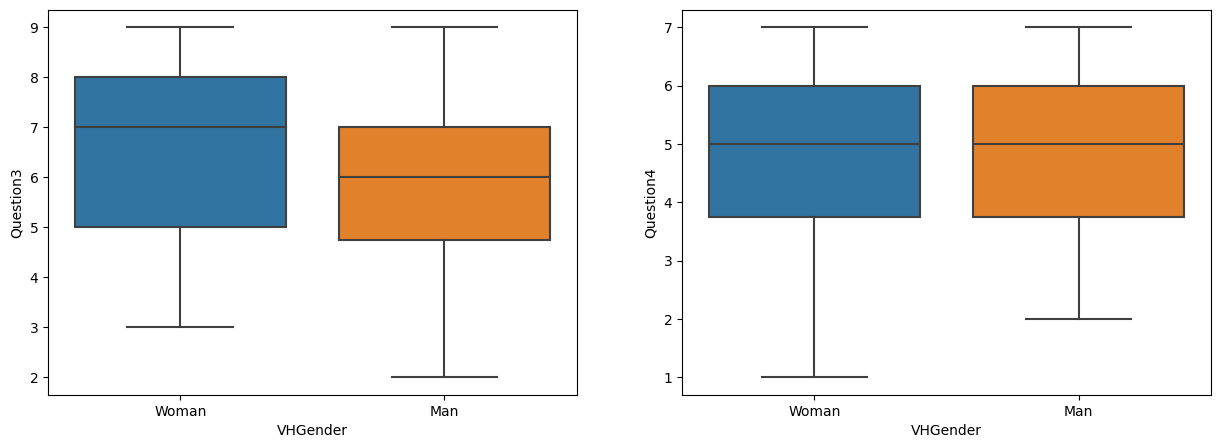

Emotion recognition (Question6 -> Valencia; Question7 -> Arousal)


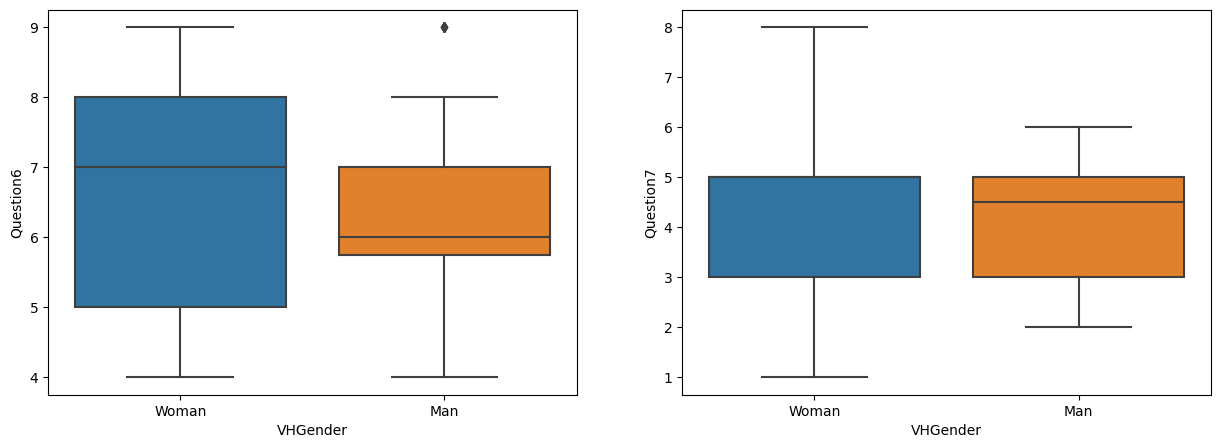


Emotion Sad
Emotion elicitation (Question3 -> Valencia; Question4 -> Arousal)


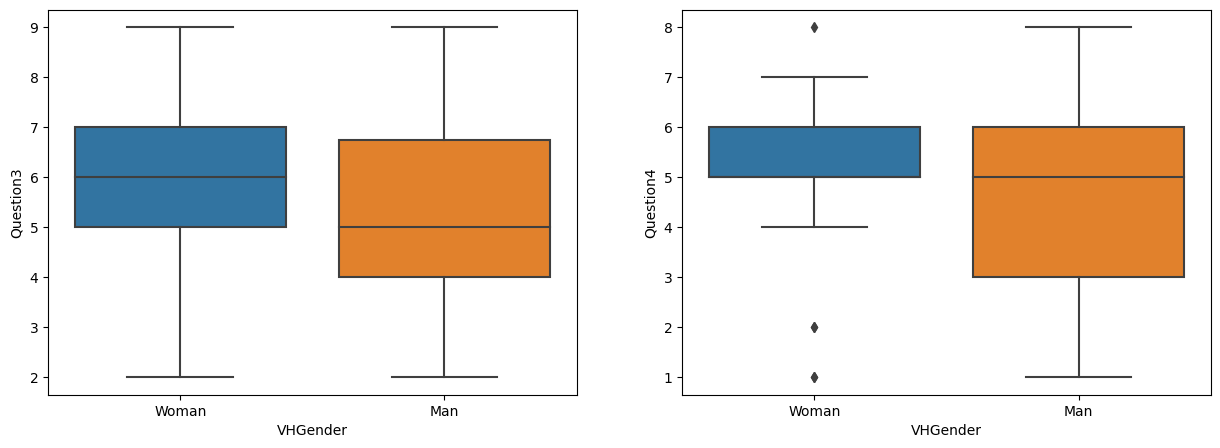

Emotion recognition (Question6 -> Valencia; Question7 -> Arousal)


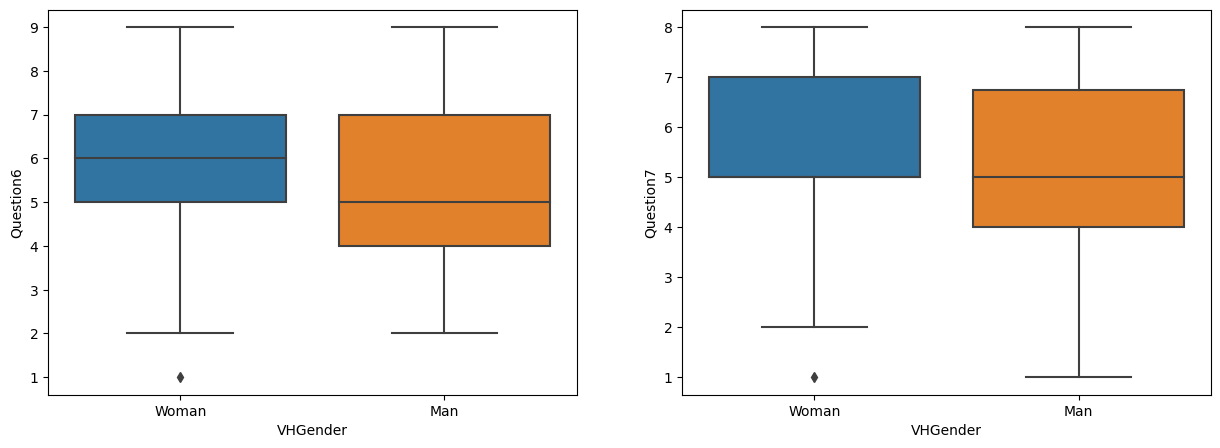


Emotion Happy
Emotion elicitation (Question3 -> Valencia; Question4 -> Arousal)


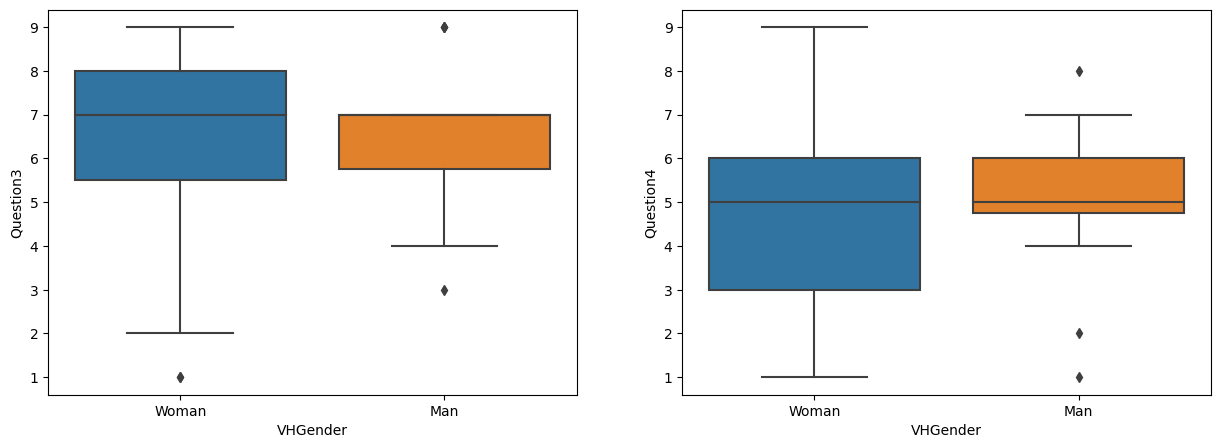

Emotion recognition (Question6 -> Valencia; Question7 -> Arousal)


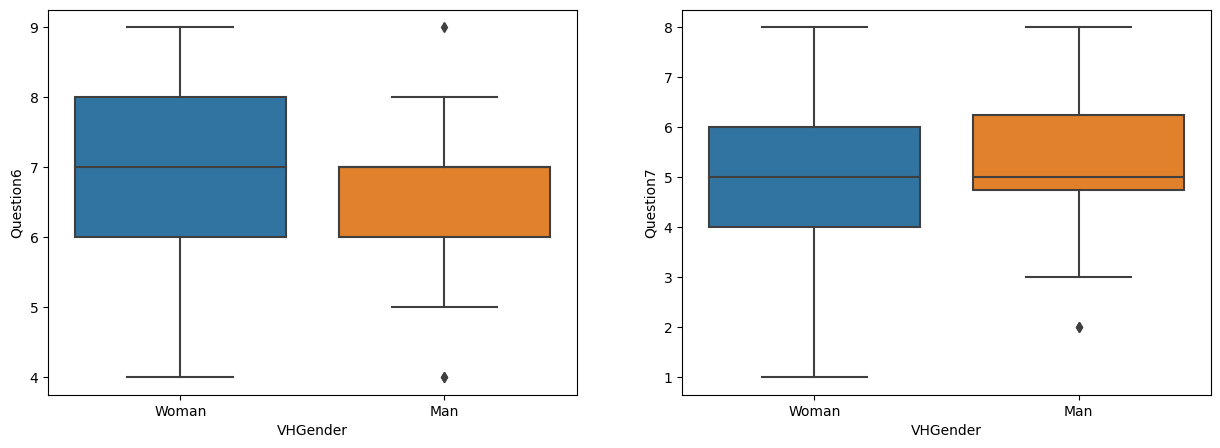

In [133]:
vh_gender_stat_diff_list = []
for emot in Parameters.emot_states:
    df_vh_man_emot = df_vh_man[df_vh_man["Personality"] == emot]
    df_vh_woman_emot = df_vh_woman[df_vh_woman["Personality"] == emot]

    for q in ["3", "4", "6", "7"]:
        _, kruskal_p_value = sp.stats.kruskal(df_vh_man_emot["Question" + q].dropna().values, df_vh_woman_emot["Question" + q].dropna().values)
        label = "Emotion elicitation" if q == "3" or q == "4" else "Emotion recognition"
        vh_gender_stat_diff_list.append({
            "Emotion": emot,
            "Question": int(q),
            "Label": label,
            "Kruskal_pvalue_Test": kruskal_p_value,
            "NumSamplesVHMan": df_vh_man_emot.shape[0],
            "NumSamplesVHWoman": df_vh_woman_emot.shape[0]
        })
    
    df_both = pd.concat([df_vh_woman_emot, df_vh_man_emot]).reset_index(drop=True)

    print("Emotion", emot)
    print("Emotion elicitation (Question3 -> Valencia; Question4 -> Arousal)")
    fig = plt.figure(figsize=(15, 5))
    fig.add_subplot(1,2,1)
    sns.boxplot(data=df_both, y="Question3", x="VHGender")
    fig.add_subplot(1,2,2)
    sns.boxplot(data=df_both, y="Question4", x="VHGender")
    plt.show()

    print("Emotion recognition (Question6 -> Valencia; Question7 -> Arousal)")
    fig = plt.figure(figsize=(15, 5))
    fig.add_subplot(1,2,1)
    sns.boxplot(data=df_both, y="Question6", x="VHGender")
    fig.add_subplot(1,2,2)
    sns.boxplot(data=df_both, y="Question7", x="VHGender")
    plt.show()
    print()

df_vh_g_stat = pd.DataFrame(vh_gender_stat_diff_list)

In [134]:
display(df_vh_g_stat)

print("Amount of samples which have statistical difference in "
      "arousal or valence in emotion recognition or elicitation for VH gender = ", 
      np.sum(df_vh_g_stat["Kruskal_pvalue_Test"] < 0.05))

,Emotion,Question,Label,Kruskal_pvalue_Test,NumSamplesVHMan,NumSamplesVHWoman
0,Angry,3,Emotion elicitation,0.887834,45,16
1,Angry,4,Emotion elicitation,0.130483,45,16
2,Angry,6,Emotion recognition,0.610912,45,16
3,Angry,7,Emotion recognition,0.121959,45,16
4,Relax,3,Emotion elicitation,0.370442,25,36
5,Relax,4,Emotion elicitation,0.937962,25,36
6,Relax,6,Emotion recognition,0.883887,25,36
7,Relax,7,Emotion recognition,0.418104,25,36
8,Sad,3,Emotion elicitation,0.245998,38,25
9,Sad,4,Emotion elicitation,0.760372,38,25


Amount of samples which have statistical difference inarousal or valence in emotion recognition or elicitation for VH gender =  0


In [94]:
df_pers_man = df_merge[df_merge["GenderFem"] == 1].reset_index(drop=True)
print("PERSON MAN", df_pers_man.shape)

df_pers_woman = df_merge[df_merge["GenderMale"] == 1].reset_index(drop=True)
print("PERSON WOMAN", df_pers_woman.shape)

PERSON MAN (127, 47)
PERSON WOMAN (117, 47)


Emotion Angry
Emotion elicitation (Question3 -> Valencia; Question4 -> Arousal)


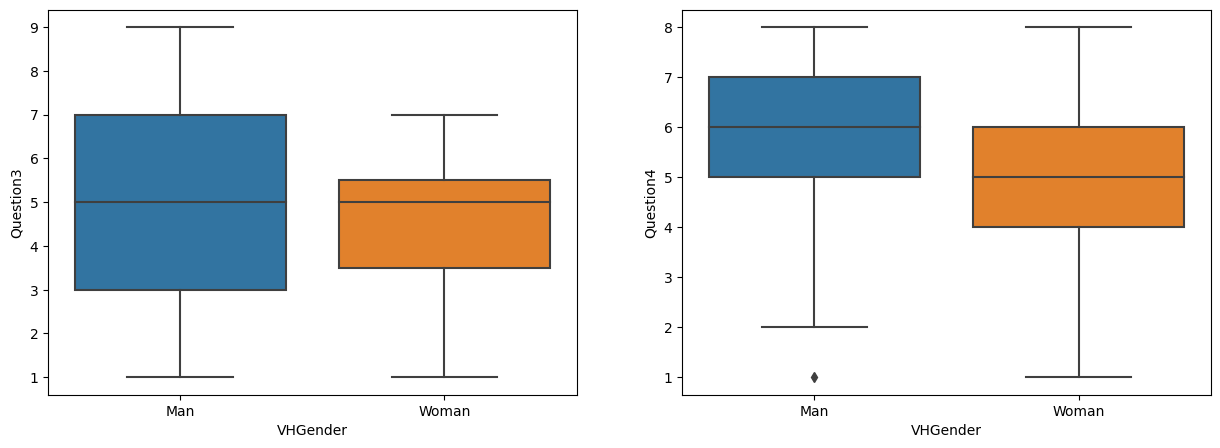

Emotion recognition (Question6 -> Valencia; Question7 -> Arousal)


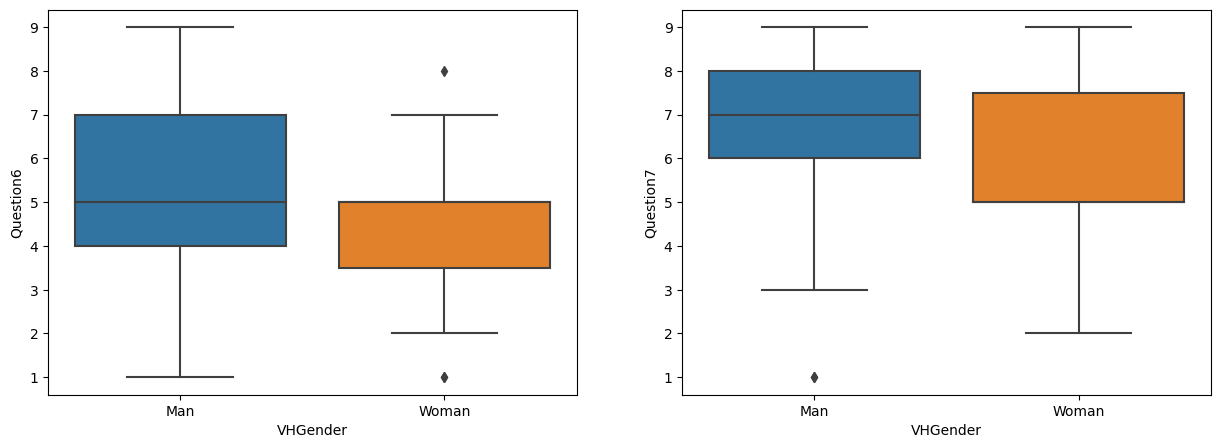


Emotion Relax
Emotion elicitation (Question3 -> Valencia; Question4 -> Arousal)


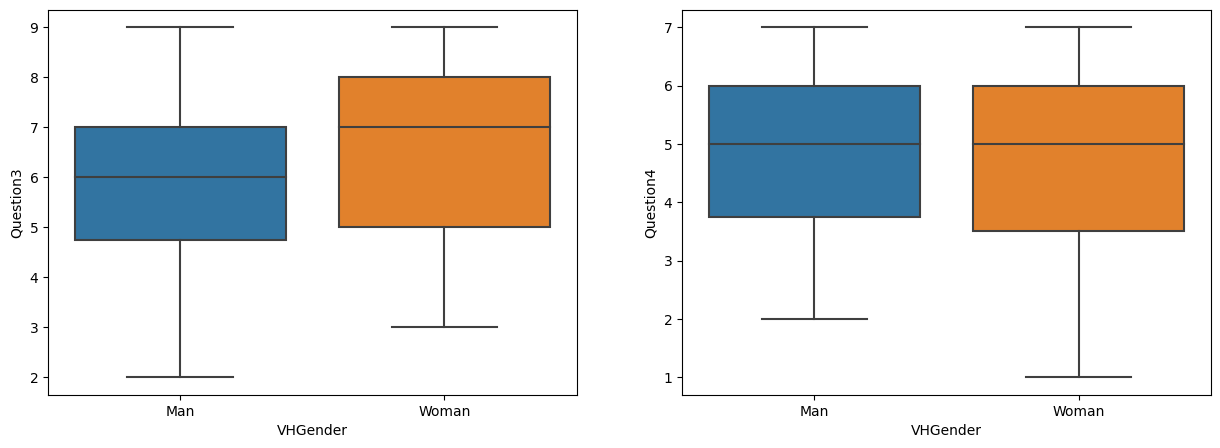

Emotion recognition (Question6 -> Valencia; Question7 -> Arousal)


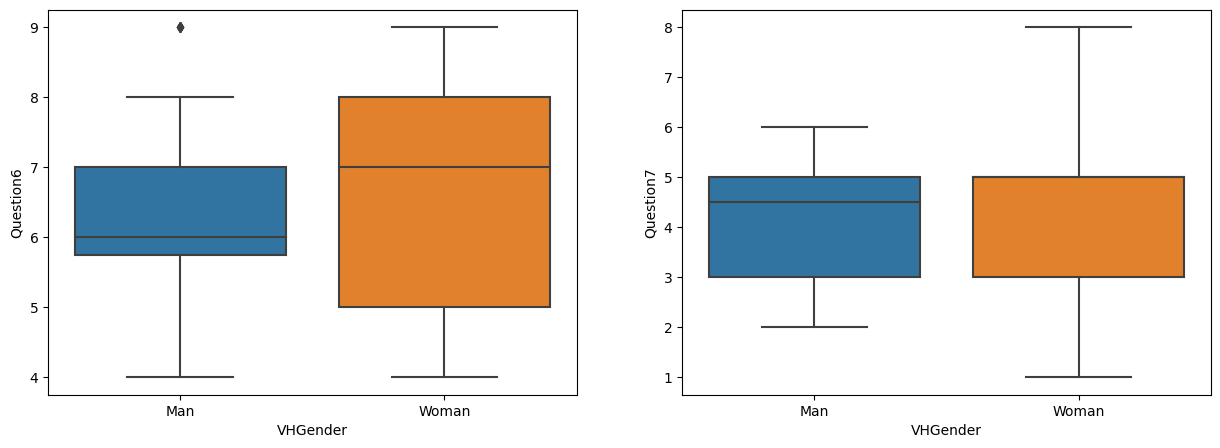


Emotion Sad
Emotion elicitation (Question3 -> Valencia; Question4 -> Arousal)


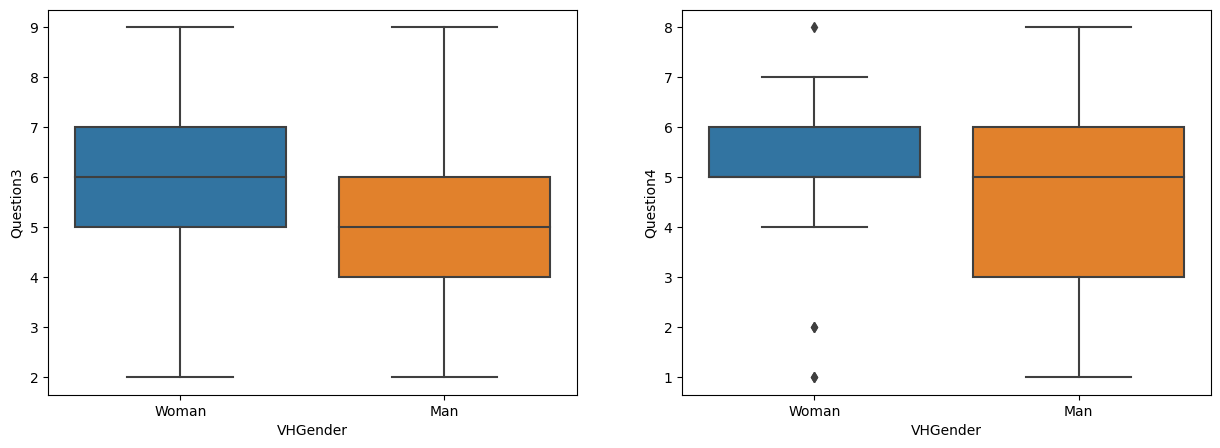

Emotion recognition (Question6 -> Valencia; Question7 -> Arousal)


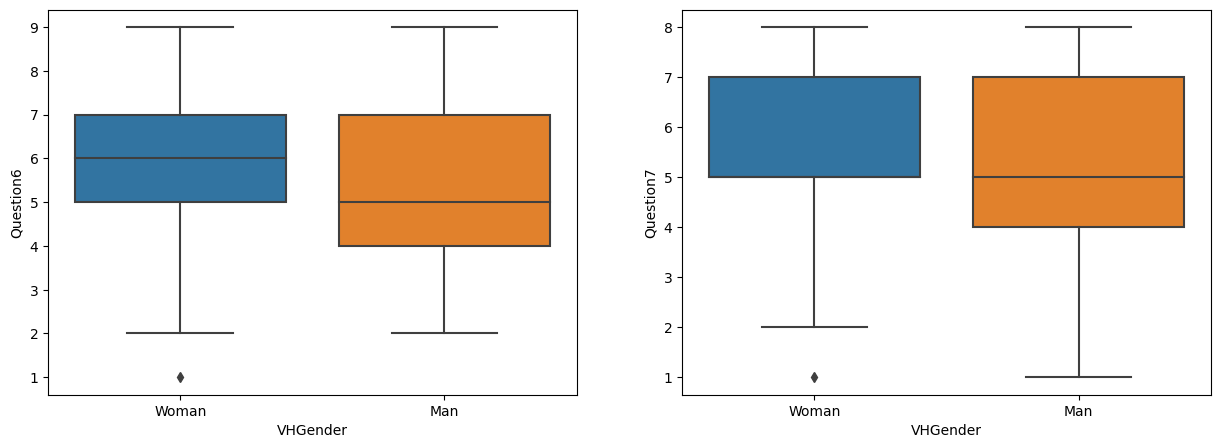


Emotion Happy
Emotion elicitation (Question3 -> Valencia; Question4 -> Arousal)


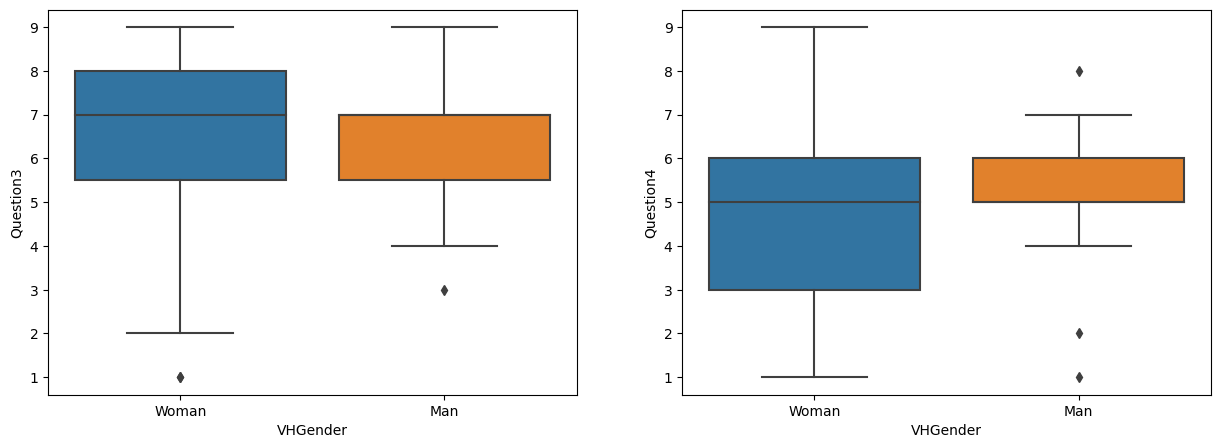

Emotion recognition (Question6 -> Valencia; Question7 -> Arousal)


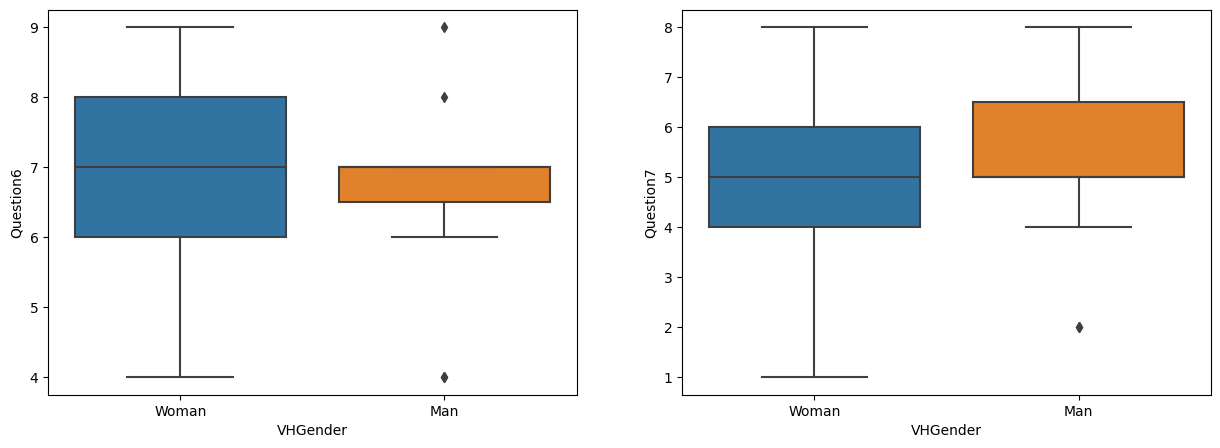

In [131]:
pers_gender_stat_diff_list = []
for emot in Parameters.emot_states:
    df_pers_man_emot = df_pers_man[df_pers_man["Personality"] == emot]
    df_pers_woman_emot = df_pers_woman[df_pers_woman["Personality"] == emot]

    for q in ["3", "4", "6", "7"]:
        _, kruskal_p_value = sp.stats.kruskal(df_pers_man_emot["Question" + q].dropna().values, df_pers_woman_emot["Question" + q].dropna().values)
        label = "Emotion elicitation" if q == "3" or q == "4" else "Emotion recognition"
        pers_gender_stat_diff_list.append({
            "Emotion": emot,
            "Question": int(q),
            "Label": label,
            "Kruskal_pvalue_Test": kruskal_p_value,
            "NumSamplesPersMan": df_pers_man_emot.shape[0],
            "NumSamplesPersWoman": df_pers_woman_emot.shape[0]
        })
    
    df_both = pd.concat([df_pers_woman_emot, df_pers_man_emot]).reset_index(drop=True)

    print("Emotion", emot)
    print("Emotion elicitation (Question3 -> Valencia; Question4 -> Arousal)")
    fig = plt.figure(figsize=(15, 5))
    fig.add_subplot(1,2,1)
    sns.boxplot(data=df_both, y="Question3", x="VHGender")
    fig.add_subplot(1,2,2)
    sns.boxplot(data=df_both, y="Question4", x="VHGender")
    plt.show()

    print("Emotion recognition (Question6 -> Valencia; Question7 -> Arousal)")
    fig = plt.figure(figsize=(15, 5))
    fig.add_subplot(1,2,1)
    sns.boxplot(data=df_both, y="Question6", x="VHGender")
    fig.add_subplot(1,2,2)
    sns.boxplot(data=df_both, y="Question7", x="VHGender")
    plt.show()
    print()

df_pers_g_stat = pd.DataFrame(pers_gender_stat_diff_list)

In [132]:
display(df_pers_g_stat)

print("Amount of samples which have statistical difference in "
      "arousal or valence in emotion recognition or elicitation for Person gender = ", 
      np.sum(df_pers_g_stat["Kruskal_pvalue_Test"] < 0.05))

,Emotion,Question,Label,Kruskal_pvalue_Test,NumSamplesPersMan,NumSamplesPersWoman
0,Angry,3,Emotion elicitation,0.140215,31,29
1,Angry,4,Emotion elicitation,0.797537,31,29
2,Angry,6,Emotion recognition,0.740505,31,29
3,Angry,7,Emotion recognition,0.752745,31,29
4,Relax,3,Emotion elicitation,0.758518,31,29
5,Relax,4,Emotion elicitation,0.155428,31,29
6,Relax,6,Emotion recognition,0.816689,31,29
7,Relax,7,Emotion recognition,0.924339,31,29
8,Sad,3,Emotion elicitation,0.897639,33,29
9,Sad,4,Emotion elicitation,0.237331,33,29


Amount of samples which have statistical difference inarousal or valence in emotion recognition or elicitation for Person gender =  0


### To check relative changes

In [138]:
time_evol_nr_list = []
for subj in subj_no_depress_list:
    
    path_to_got = "../Conversations/" + subj + "_Conversations/GuideOfTimes.csv"
    
    try:
        df_got = pd.read_csv(path_to_got, sep=";")
    except:
        print("Bad subject", path_to_got)
        continue

    order_appear = 0
    for i in range(0, df_got.shape[0], 2):

        event = df_got["Event"].iloc[i]
        if "_" not in event:
            continue

        emotion, gender, vh_form, _ = event.split("_")
        
        time_evol_nr_list.append({
            "Subject": subj,
            "VHEmotion": emotion,
            "VHGender": gender,
            "VHForm": vh_form,
            "OrderAppear": order_appear
        })

        order_appear += 1

df_order_vh_info = pd.DataFrame(time_evol_nr_list)
display(df_order_vh_info.head(10))

print("Shape of the data", df_order_vh_info.shape)

Bad subject ../Conversations/USER_48_CB2_Conversations/GuideOfTimes.csv
Bad subject ../Conversations/USER_47_CB2_Conversations/GuideOfTimes.csv


,Subject,VHEmotion,VHGender,VHForm,OrderAppear
0,USER_45_CB2,Neutral,Female,1,0
1,USER_45_CB2,Neutral,Male,2,1
2,USER_45_CB2,Happy,Woman,1,2
3,USER_45_CB2,Relax,Man,2,3
4,USER_45_CB2,Sad,Woman,2,4
5,USER_45_CB2,Angry,Man,1,5
6,USER_43_CB2,Neutral,Female,1,0
7,USER_43_CB2,Neutral,Male,2,1
8,USER_43_CB2,Angry,Woman,2,2
9,USER_43_CB2,Sad,Man,2,3


Shape of the data (377, 5)


In [145]:
df_merge = df_all_cuest.merge(df_order_vh_info, left_on=["SubjectId", "Personality"], right_on=["Subject", "VHEmotion"])
demo_cols_list = ['AgeYears', 'GenderFem', 'GenderOther', 'NumHPlayVGame', 'PlayVGame', 'OrdinalPs', 'NoMedicine', 'SubjectId', 'GenderMale']
df_merge = df_merge.merge(df_demo[demo_cols_list], left_on="SubjectId", right_on="SubjectId")

cols_to_drop = [
    'Unnamed: 0', 'respondent_id', 'collector_id', 'date_created',
    'date_modified', 'ip_address', 'email_address', 'first_name',
    'last_name', 'custom_1'
]

df_merge = df_merge.drop(columns=cols_to_drop)
df_merge

,Usuario,Question1,Question2,Question3,Question4,Question5,Question6,Question7,Question8,Disgusto,...,VHForm,OrderAppear,AgeYears,GenderFem,GenderOther,NumHPlayVGame,PlayVGame,OrdinalPs,NoMedicine,GenderMale
0,USER_45_CB2,3.0,3.0,7.0,7.0,6.0,7.0,6.0,5.0,10.0,...,1,5,33.89,0,0,1.0,1,0,1,1
1,USER_45_CB2,3.0,3.0,6.0,7.0,6.0,7.0,5.0,5.0,12.0,...,1,2,33.89,0,0,1.0,1,0,1,1
2,USER_45_CB2,3.0,3.0,7.0,5.0,6.0,7.0,5.0,5.0,11.0,...,2,3,33.89,0,0,1.0,1,0,1,1
3,USER_45_CB2,3.0,3.0,7.0,6.0,6.0,7.0,5.0,5.0,10.0,...,2,4,33.89,0,0,1.0,1,0,1,1
4,USER_43_CB2,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,...,2,2,42.29,0,0,NaN,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,User_01_CB,5.0,4.0,5.0,5.0,8.0,5.0,5.0,3.0,1.0,...,2,5,23.65,0,0,1.0,1,0,1,1
244,USER_39_CB2,4.0,2.0,1.0,9.0,7.0,6.0,3.0,2.0,81.0,...,1,2,49.24,1,0,NaN,0,0,1,0
245,USER_39_CB2,7.0,5.0,5.0,5.0,8.0,4.0,7.0,6.0,52.0,...,2,1,49.24,1,0,NaN,0,0,1,0
246,USER_10_CB2,7.0,7.0,9.0,7.0,7.0,8.0,5.0,5.0,0.0,...,2,2,46.84,1,0,NaN,0,0,1,0


Emotion Angry
{'Angry -> Happy': 13, 'Angry -> Relax': 15, 'Angry -> Sad': 10}


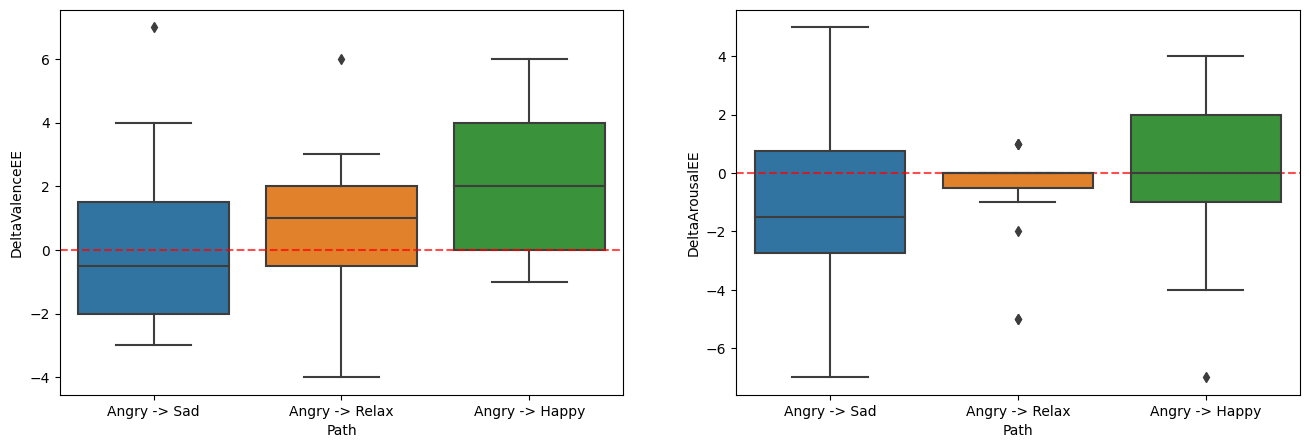

Emotion Happy
Problems
Problems
Problems
{'Happy -> Angry': 13, 'Happy -> Relax': 17, 'Happy -> Sad': 14}


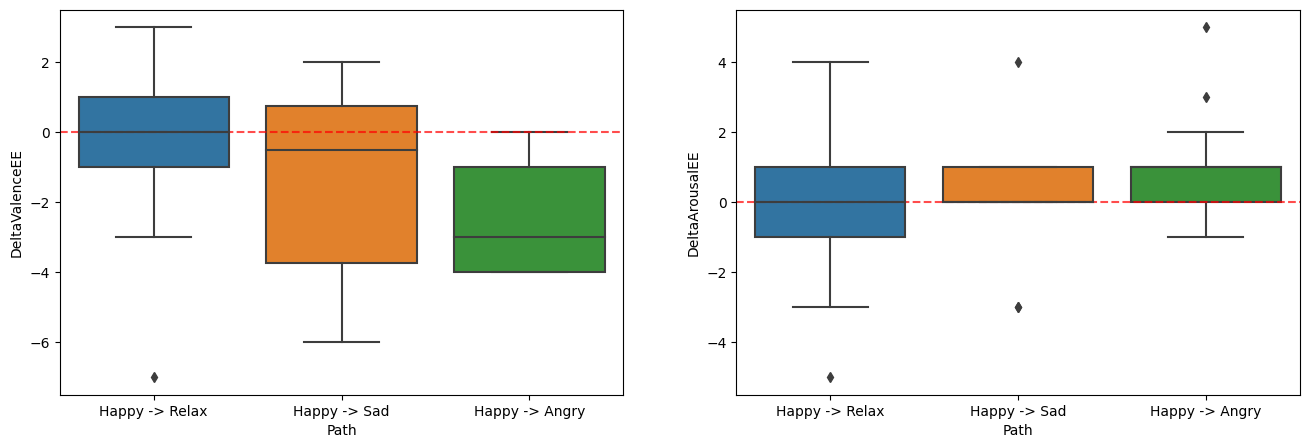

Emotion Relax
{'Relax -> Angry': 12, 'Relax -> Happy': 12, 'Relax -> Sad': 21}


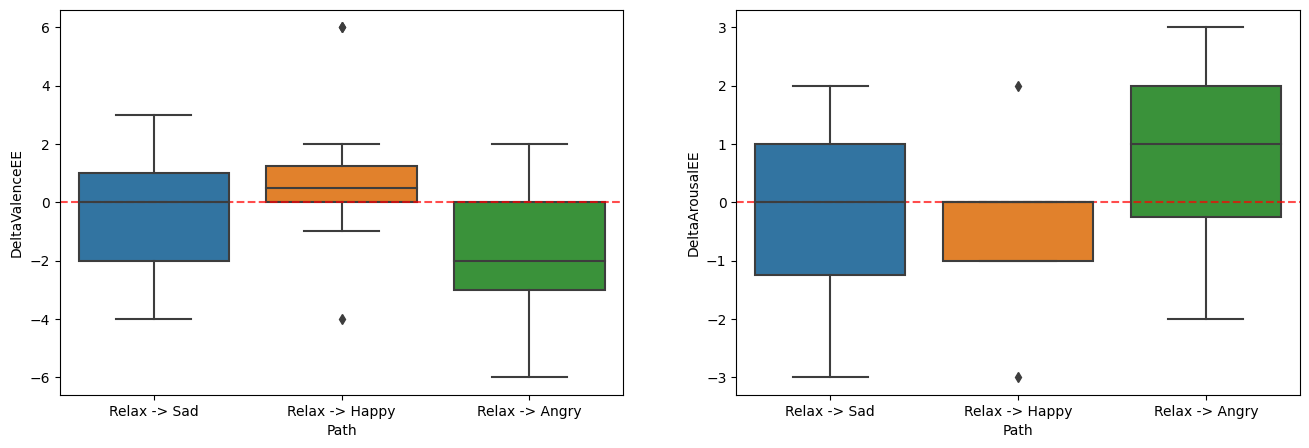

Emotion Sad
{'Sad -> Angry': 14, 'Sad -> Happy': 17, 'Sad -> Relax': 13}


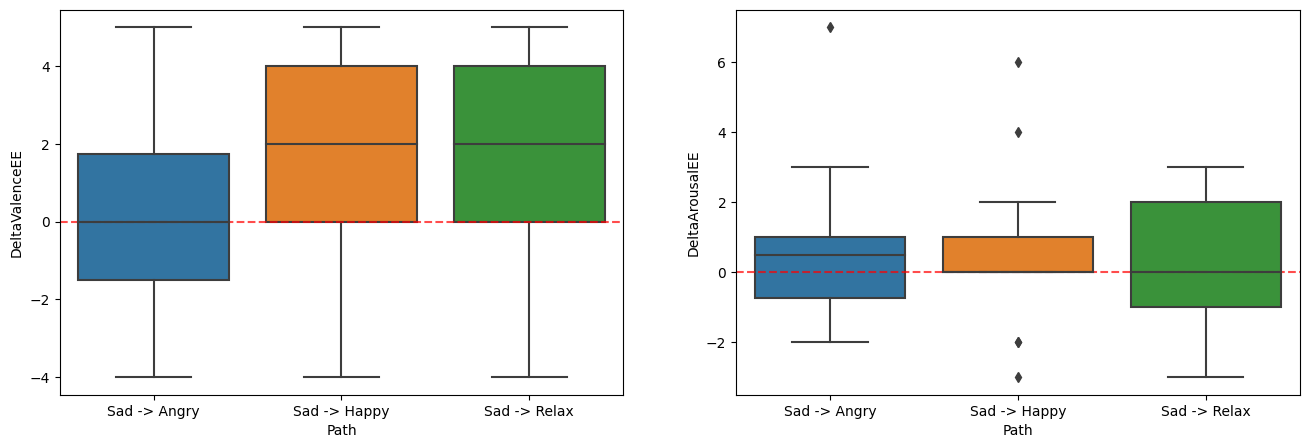

In [166]:
for em, df_em in df_merge.groupby("VHEmotion"):

    print("Emotion", em)

    # rest_emotions = [e for e in Parameters.emot_states if e != em]

    save_data_list = []
    for i in range(df_em.shape[0]):

        user = df_em["Usuario"].iloc[i]
        actual_order_vh_emot = df_em["OrderAppear"].iloc[i]

        if actual_order_vh_emot >= 5:
            continue

        future_order_vh_emot = actual_order_vh_emot + 1

        df_fut_vh = df_merge[(df_merge["Usuario"] == user) & (df_merge["OrderAppear"] == future_order_vh_emot)]

        if df_fut_vh.shape[0] != 1:
            print("Problems")
            continue
        
        em_future = df_fut_vh["VHEmotion"].iloc[0]

        if em == em_future:
            continue
        
        save_data_list.append({
            "Subject": user,
            "Path": em + " -> " + em_future,
            "DeltaValenceEE": df_fut_vh["Question3"].iloc[0] - df_em["Question3"].iloc[i],
            "DeltaArousalEE": df_fut_vh["Question4"].iloc[0] - df_em["Question4"].iloc[i],
            "DeltaValenceEI": df_fut_vh["Question6"].iloc[0] - df_em["Question6"].iloc[i],
            "DeltaArousalEI": df_fut_vh["Question7"].iloc[0] - df_em["Question7"].iloc[i],
        })

    df_path_emot = pd.DataFrame(save_data_list)
    print({k:df_k.shape[0] for k, df_k in df_path_emot.groupby("Path")})

    fig = plt.figure(figsize=(16, 5))
    fig.add_subplot(1,2,1)
    sns.boxplot(data=df_path_emot, x="Path", y="DeltaValenceEE")
    plt.axhline(0, linestyle="--", c="red", alpha=0.7)
    
    fig.add_subplot(1,2,2)
    sns.boxplot(data=df_path_emot, x="Path", y="DeltaArousalEE")
    plt.axhline(0, linestyle="--", c="red", alpha=0.7)
    
    plt.show()

Analysis through Kullback-Leibler or Hotelling's T-squared test ? -> for multivariate analysis

For univariate I could analyse the emotions that should be at equal arousal or equal valence against the ones that not.

## Stai study

In [230]:
df_stai = pd.read_excel("../Cuestionarios/CHATBOTs_STAI-Y1.xlsx", skiprows=[1])
print(df_stai.shape)
print(df_stai.columns)

(109, 30)
Index(['respondent_id', 'collector_id', 'date_created', 'date_modified',
       'ip_address', 'email_address', 'first_name', 'last_name', 'custom_1',
       'Usuario',
       'A continuación, encontrará unas frases que se utilizan corrientemente para describirse uno a sí mismo. Lea cada frase y señale la puntuación de "nada" a "mucho" que indique mejor cómo se siente usted ahora mismo, en este momento. No hay respuestas buenas ni malas. No emplee demasiado tiempo en cada frase y conteste señalando la respuesta que mejor describa su situación actual.',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29'],
      dtype='object')


In [231]:
old_columns = df_stai.columns[10:]
new_cols_stai = ["Question_" + str(i+1) for i in range(len(old_columns))]
print(new_cols_stai)

df_stai = df_stai.rename(columns=dict(zip(old_columns, new_cols_stai)))

['Question_1', 'Question_2', 'Question_3', 'Question_4', 'Question_5', 'Question_6', 'Question_7', 'Question_8', 'Question_9', 'Question_10', 'Question_11', 'Question_12', 'Question_13', 'Question_14', 'Question_15', 'Question_16', 'Question_17', 'Question_18', 'Question_19', 'Question_20']


In [232]:
positive_num = [3,4,6,7,9,12,13,14,17,18]
positive_cols = ["Question_" + str(i) for i in positive_num]

positive_help_dict = {"Nada": 0, "Algo": 1, "Bastante": 2, "Mucho": 3}

for cols in positive_cols:
    df_stai["Numeric_" + cols] = df_stai[cols].replace(positive_help_dict)

negative_num = [1,2,5,8,10,11,15,16,19,20]
negative_cols = ["Question_" + str(i) for i in negative_num]

negative_help_dict = {"Nada": 3, "Algo": 2, "Bastante": 1, "Mucho": 0}

for cols in negative_cols:
    df_stai["Numeric_" + cols] = df_stai[cols].replace(negative_help_dict)

In [234]:
numeric_quest_cols = ["Numeric_" + cols for cols in new_cols_stai]
numeric_quest_cols

['Numeric_Question_1',
 'Numeric_Question_2',
 'Numeric_Question_3',
 'Numeric_Question_4',
 'Numeric_Question_5',
 'Numeric_Question_6',
 'Numeric_Question_7',
 'Numeric_Question_8',
 'Numeric_Question_9',
 'Numeric_Question_10',
 'Numeric_Question_11',
 'Numeric_Question_12',
 'Numeric_Question_13',
 'Numeric_Question_14',
 'Numeric_Question_15',
 'Numeric_Question_16',
 'Numeric_Question_17',
 'Numeric_Question_18',
 'Numeric_Question_19',
 'Numeric_Question_20']

In [235]:
df_stai["ScoreStai"] = np.nansum(df_stai[numeric_quest_cols], axis=1)

In [242]:
df_stai.index = [usr.upper() for usr in df_stai["Usuario"].values]
df_stai_no_depress = df_stai.loc[Parameters.subj_no_depress_list]
df_stai_no_depress

,respondent_id,collector_id,date_created,date_modified,ip_address,email_address,first_name,last_name,custom_1,Usuario,...,Numeric_Question_2,Numeric_Question_5,Numeric_Question_8,Numeric_Question_10,Numeric_Question_11,Numeric_Question_15,Numeric_Question_16,Numeric_Question_19,Numeric_Question_20,ScoreStai
USER_48_CB2,114255672922,423132386,2023-02-27 11:05:00,2023-02-27 11:16:06,158.42.142.216,NaN,NaN,NaN,NaN,USER_48_CB2,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,15.0
USER_47_CB2,114255605646,423132386,2023-02-27 08:58:33,2023-02-27 09:10:38,158.42.142.216,NaN,NaN,NaN,NaN,USER_47_CB2,...,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,18.0
USER_45_CB2,114253781944,423132386,2023-02-24 11:26:18,2023-02-24 11:33:31,158.42.142.216,NaN,NaN,NaN,NaN,USER_45_CB2,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,35.0
USER_43_CB2,114252775252,423132386,2023-02-23 12:59:56,2023-02-23 13:05:28,158.42.142.216,NaN,NaN,NaN,NaN,USER_43_CB2,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,14.0
USER_42_CB2,114252709219,423132386,2023-02-23 08:30:47,2023-02-23 11:13:43,158.42.142.216,NaN,NaN,NaN,NaN,USER_42_CB2,...,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USER_07_CB,114179789360,423132386,2022-11-18 08:29:50,2022-11-18 08:59:21,158.42.69.160,NaN,NaN,NaN,NaN,User_07_CB,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
USER_05_CB,114178695138,423132386,2022-11-17 10:48:51,2022-11-17 11:17:58,158.42.69.160,NaN,NaN,NaN,NaN,User_05_CB,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,15.0
USER_03_CB,114177532198,423132386,2022-11-16 13:01:51,2022-11-16 13:11:15,158.42.69.160,NaN,NaN,NaN,NaN,User_03_CB,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
USER_02_CB,114177440864,423132386,2022-11-16 10:35:13,2022-11-16 10:54:53,158.42.69.160,NaN,NaN,NaN,NaN,User_02_CB,...,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0


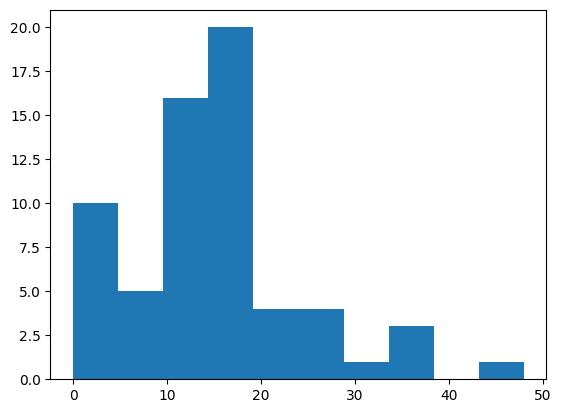

In [245]:
plt.hist(df_stai_no_depress["ScoreStai"])

plt.show()

In [246]:
sp.stats.shapiro(df_stai_no_depress["ScoreStai"].values)

ShapiroResult(statistic=0.9373728632926941, pvalue=0.0028680842369794846)

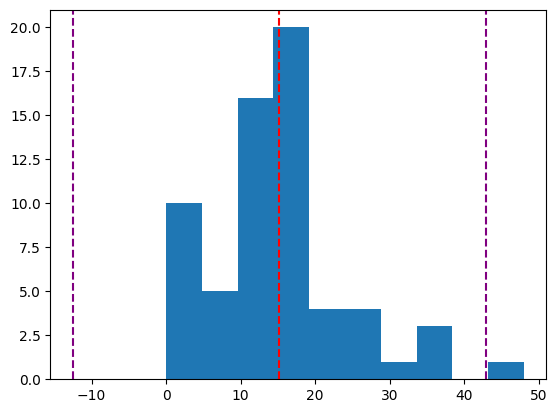

Mean Stai Score = 15.2031 +/- 9.2334 ; Median = 15.0 ; Min. =  0.0 ; Max. =  48.0


In [256]:
mean_distr = np.mean(df_stai_no_depress["ScoreStai"])
std_distr = np.std(df_stai_no_depress["ScoreStai"])

plt.hist(df_stai_no_depress["ScoreStai"])

plt.axvline(mean_distr, linestyle="--", c="red")
plt.axvline(mean_distr-3*std_distr, linestyle="--", c="purple")
plt.axvline(mean_distr+3*std_distr, linestyle="--", c="purple")

plt.show()

aute.stat_print(df_stai_no_depress["ScoreStai"].values, "Stai Score")

In [255]:
bad_subj_out = df_stai_no_depress[
    (df_stai_no_depress["ScoreStai"] > mean_distr + 3*std_distr) | (df_stai_no_depress["ScoreStai"] < mean_distr- 3*std_distr)
].index
print("Bad subjects", bad_subj_out)

Bad subjects Index(['USER_49_CB'], dtype='object')


In [260]:
df_stai_no_depress["ScoreStai"].values[np.argsort(df_stai_no_depress["ScoreStai"].values)[::-1][:5]]

array([48., 36., 36., 35., 29.])